In [4]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

In [6]:
df = pd.read_csv('./data_RF.csv', )
df_date = df.set_index('Date').copy()

In [7]:
target = list(df_date.columns)

In [8]:
target[0:-1]

['Adj Close',
 'Fast %K',
 'Slow %K(D)',
 'Slow %D(J)',
 'J Binary(80%)',
 'J Binary(50%)',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'macd',
 'macds',
 'macdo',
 'VIX',
 'Bullish',
 'Neutral',
 'Bearish',
 'Bullish 8-Week Mov Avg',
 'Bull-Bear Spread',
 'Fear Greed',
 'Put Call']

In [9]:
df_test = df_date.loc['2020-01-01':'2020-09-01']
df_train = df_date.loc['2011-02-15':'2019-12-31']

In [10]:
predictors = target[0:-1]
goal = target[-1]

In [11]:
train_X = df_train[predictors]
train_y = df_train[goal]

test_X = df_test[predictors]
test_y = df_test[goal]

In [12]:
def modelfit(alg, train, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = param
        xgtrain = xgb.DMatrix(train[predictors].values, label=train[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=param['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        xgb_param['n_estimators']=cvresult.shape[0]
        alg.set_params(**xgb_param)
    
    #Fit the algorithm on the data
    alg.fit(train[predictors], train[target],eval_metric='auc')
        
    #Predict training set:
    train_predictions = alg.predict(train[predictors])
    train_predprob = alg.predict_proba(train[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(cvresult.shape[0])
    print("Accuracy : %.4g" % metrics.accuracy_score(train[target].values, train_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train[target], train_predprob))
                    
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [13]:
param = {}

param['eta'] = 0.1
param['n_estimators'] = 1000
param['max_depth'] = 5
param['min_child_weight'] = 1
param['gamma'] = 0
param['subsample'] = 0.8
param['colsample_bytree'] = 0.8
param['objective'] = 'binary:logistic'
param['scale_pos_weight'] = 1

In [14]:
xgb1 = XGBClassifier(**param)

[19:25:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:25:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:25:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

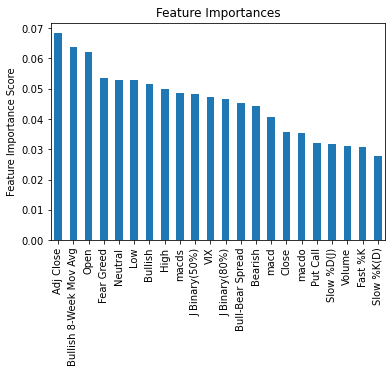

In [15]:
modelfit(xgb1, df_train, predictors, goal)

In [17]:
adj_param = param
adj_param['n_estimators'] = 631

In [18]:
def param_test(original_param, test_param, train = df_train, predictors = predictors, target = goal):
    gsearch = GridSearchCV(estimator = XGBClassifier(**original_param), param_grid = test_param, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
    gsearch.fit(train[predictors],train[target])
    print(gsearch.best_params_)

In [ ]:
test_param = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
param_test(adj_param, test_param)

In [15]:
test_param = {'max_depth':[2,3,4,5],'min_child_weight':[2,3,4,5]}
param_test(adj_param, test_param)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\JIN\anaconda3\lib\site-packages\joblib\parallel.py", line 921, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "C:\Users\JIN\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "C:\Users\JIN\anaconda3\lib\concurrent\futures\_base.py", line 434, in result
    self._condition.wait(timeout)
  File "C:\Users\JIN\anaconda3\lib\threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\JIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1188, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\JIN

TypeError: object of type 'NoneType' has no len()

In [ ]:
adj_param['max_depth'] = 2
adj_param['min_child_weight'] = 0

In [ ]:
test_param = {'gamma':[i/100 for i in range(0,100)]}
param_test(adj_param, test_param)

In [ ]:
adj_param['gamma'] = 0.8

In [ ]:
test_param = {'subsample':[i/10.0 for i in range(0,10)],'colsample_bytree':[i/10.0 for i in range(0,10)]}
param_test(adj_param, test_param)

In [ ]:
test_param = {'subsample':[i/100.0 for i in range(80,100)],'colsample_bytree':[i/100.0 for i in range(0,10)]}
param_test(adj_param, test_param)

In [ ]:
adj_param['colsample_bytree'] = 0
adj_param['subsample'] = 0.88

In [ ]:
test_param = {'reg_alpha':[0.00001,0.0001,0.001,0.01, 0.1, 1, 100]}
param_test(adj_param, test_param)

In [ ]:
test_param = {'reg_alpha':[i/1000000 for i in range(0,100)]}
param_test(adj_param, test_param)

In [ ]:
adj_param['reg_alpha'] = 3.3e-05
adj_param['eta'] = 0.01

In [ ]:
adj_param

In [ ]:
xgb2 = XGBClassifier(**adj_param)

In [ ]:
modelfit(xgb2, df_train, predictors, goal)

In [22]:
result = xgb1.predict(test_X)

In [27]:
score_up = 0
match_up = 0

score_down = 0
match_down = 0


for i in range(0, len(result)):
    if result[i] == test_y[i]:
        if result[i] == 0:
            score_down += 1
            match_down += 1
        else:
            score_up += 1
            match_up += 1
    else:
        if result[i] == 0:
            score_down += 1
        else:
            score_up += 1


print(match_up/score_up)
print(match_down/score_down)

0.6932515337423313
0.16666666666666666


In [28]:
pred = xgb1.predict(test_X)
accuracy = accuracy_score(test_y, pred)
print('XGBoost 정확도: {:.4f}'.format(accuracy))

XGBoost 정확도: 0.6746


In [29]:
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [31]:
for i in range()

test_y.values

array([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
test_y.values

In [ ]:
pred

In [ ]:
from keras.models import load_model

In [ ]:
# xgb2.save_model('XGBoostCLF.model')
# xgb3 = XGBClassifier()
# xgb3.load_model('XGBoostCLF.model')

In [ ]:
pred = xgb1.predict(test_X)

In [ ]:
pred

In [ ]:
test_y.values